# Objective
* 탐지 미탐지 sequence 에서 일정 구간 추출하기

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import cv2
import logging
import matplotlib.pyplot as plt
import numpy as np

In [105]:
# obj_status=[0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,1,0,0,1,1,1,1,0,0,0,0,0,]
pattern1=[0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,1,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0]
pattern0=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
pattern2=[0,0, 0]
pattern3=[0,0,0,0,1,0,1,1,1,1,0,1,0,0]
object_status=pattern2

In [106]:
def smooth(object_status):
    wlen = min(5, len(object_status))
    T = 1. / wlen
    w = np.ones(wlen)
    status = np.convolve(w / w.sum(), object_status, mode='same')
    return status

In [107]:
status=smooth(object_status)
print(status)
n=len(status)
n

[0. 0. 0.]


3

Trigger = True
연속적으로 T 이상인 구간이 없음 [0, 0, 0]
margin 을 추가한 연속 구간 [4], None


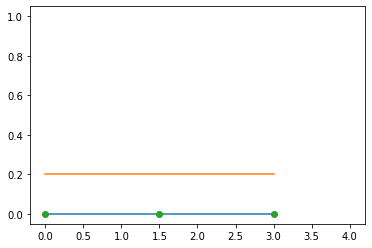

In [110]:
true_region_start=3
true_region_end=29
frame_margin = 3

# 언제 trigger 할 것인가?
# 마지막이 0이고 왼쪽으로 T만큼 0이 반복되면 trigger
idx0=np.argwhere(status[::-1] < T)
trigger=np.sum(idx0[0:frame_margin])==np.sum(range(frame_margin))
print(f'Trigger = {trigger}')

# 1st step : 연속적으로 T 이상인 index를 찾자
idx=np.argwhere(status >= T)
if len(idx) == 0:
    del object_status[0:n-frame_margin]
    print(f'연속적으로 T 이상인 구간이 없음 {object_status}')
else:
    s0=idx[0]
    e0=idx[-1]
    print(f'연속적으로 T 이상인 구간 {s0} {e0}')
    
# 2nd step : s0, e0 에서 frame_margin 만큼 확장하자
# 2-1 : s0-frame_margin >= 0   # s1 = s0-frame_margin
# 2-2 : s0-frame_margin < 0    # s1 = max(0, s0-frame_margin)
s1 = max(0, s0-frame_margin)
# 2-3 : e0+frame_margin < n    # e1 = e0+frame_margin
if e0+frame_margin < n:
    e1 = e0+frame_margin
else:
# 2-4 ; e0+frame_margin >= n    # e1 = None (다음 state 가 1이될 가능성이 있으므로 기다린다)
    e1 = None
    
print(f'margin 을 추가한 연속 구간 {s1}, {e1}')


x=np.linspace(0, n, n)
plt.plot(x, status)
plt.plot(x, np.ones(n)*T)
plt.plot(x, np.array(object_status), 'o')
plt.plot([s1, e1], [1, 1])

# step#3 : 0 부터 e1 까지 지운다
